In [2]:
import torch_ac_simple
from torch_ac_simple import PlotEvalData, plot_eval
import matplotlib.pyplot as plt
import shutil
import os

EMPTY_ENV = "MiniGrid-Empty-Random-6x6-v0"
GO_TO_OBJ_ENV = "MiniGrid-GoToObject-6x6-N2-v0"

In [8]:
# train control model for fetch
agent = torch_ac_simple.Agent(GO_TO_OBJ_ENV, "a2c_fetch_control", num_envs=16)
if agent.frames_trained() == 0:
    agent.eval(100)
for i in range(50):
    if agent.train(1e4*(i+1), 'a2c'):
        agent.eval(100)

Environments loaded

F 300.0 | FPS 6334 | D 0 | R:μσmM 0.06 0.23 0.00 1.00 | F:μσmM 3.0 2.7 1.0 16.0
0 frames
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
  )
  (actor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
  (critic): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

U 1 | F 000128 | FPS 2437 | D 0 | R:μσmM 0.16 0.36 0.00 1.00 | F:μσmM 2.1 1.3 1.0 6.0 | H 1.906 | V -0.213 | pL 0.484 | vL 0.155 | ∇ 1.611
Status saved
U 2 | F 000256 | FPS 2548 | D 0 | R:μ

In [9]:
# train base model for transfer learning
agent = torch_ac_simple.Agent(EMPTY_ENV, "a2c_empty", num_envs=2)
for i in range(50):
    agent.train(1e4*(i+1), 'a2c')

0 frames
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
  )
  (actor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
  (critic): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

U 1 | F 000016 | FPS 0726 | D 0 | R:μσmM 0.00 0.00 0.00 0.00 | F:μσmM 0.0 0.0 0 0 | H 1.908 | V -0.244 | pL 0.100 | vL 0.005 | ∇ 0.360
Status saved
U 2 | F 000032 | FPS 0982 | D 0 | R:μσmM 0.00 0.00 0.00 0.00 | F:μσmM 0.0 0.0 0 0 | H 1.384 | V 1.882 | pL -0.072 | vL 0.006 | ∇ 0.582
Status 

In [13]:
# Setup TL models
os.makedirs(os.path.dirname("storage/a2c_fetch_tl/status.pt"), exist_ok=True)
shutil.copy2("storage/a2c_empty/status.pt", "storage/a2c_fetch_tl/status.pt")
os.makedirs(os.path.dirname("storage/a2c_fetch_tl_w_rs/status.pt"), exist_ok=True)
shutil.copy2("storage/a2c_empty/status.pt", "storage/a2c_fetch_tl_w_rs/status.pt")

'storage/a2c_fetch_tl_w_rs/status.pt'

In [5]:
import numpy as np
import minigrid.core.constants as constants

MAX_REWARD = 1
COLOR_NAMES = constants.COLOR_NAMES
OBJECT_NAMES = sorted(list(constants.OBJECT_TO_IDX.keys()))
ACTION_NAMES = ["get"]
ACTION_TO_ACTIONS = {
    "get": [0,1,2]
}

def reshape_reward(obs, action, reward, done):
    # no need to reshape if done
    if done:
        return reward
    
    # guess target tile
    mission = obs['mission']
    if mission is None:
        return reward
    for color in COLOR_NAMES:
        if color in mission:
            target_color = color
            break
    for obj in OBJECT_NAMES:
        if obj in mission:
            target_obj = obj
            break
    target = np.array([constants.OBJECT_TO_IDX[target_obj], constants.COLOR_TO_IDX[target_color], 0])

    # find target tile
    target_pos = None
    for x,r in enumerate(obs['image']):
        for y,c in enumerate(r):
            if np.array_equal(c, target):
                target_pos = np.array([x,y])
                break
        if target_pos is not None:
            break
    if target_pos is not None:
        # give reward based on distance to target
        man_dist = find_manhattan_distance(target_pos, np.array([3,4]))
        if man_dist > 0:
            reward += 1/(man_dist*50)
    return MAX_REWARD if reward > MAX_REWARD else reward

def find_manhattan_distance(p1, p2):
    return np.sum(np.abs(p1-p2))

In [3]:
# train tl only model
agent = torch_ac_simple.Agent(GO_TO_OBJ_ENV, "a2c_fetch_tl", num_envs=16)
agent.eval(100)
for i in range(50, 100):
    if agent.train(1e4*(i+1), 'a2c'):
        agent.eval(100)

Environments loaded

F 300.0 | FPS 6254 | D 0 | R:μσmM 0.06 0.23 0.00 1.00 | F:μσmM 3.0 2.7 1.0 16.0
1000096 frames
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
  )
  (actor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
  (critic): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

Status saved
1000096 frames
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size

In [6]:
# train tl w rs model
agent = torch_ac_simple.Agent(GO_TO_OBJ_ENV, "a2c_fetch_tl_w_rs", num_envs=16)
agent.eval(100)
for i in range(50, 100):
    if agent.train(1e4*(i+1), 'a2c', algo_config=torch_ac_simple.Config(reshape_reward=reshape_reward)):
        agent.eval(100)

Environments loaded

F 300.0 | FPS 5100 | D 0 | R:μσmM 0.06 0.23 0.00 1.00 | F:μσmM 3.0 2.7 1.0 16.0
920096 frames
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
  )
  (actor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
  (critic): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

Status saved
920096 frames
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(

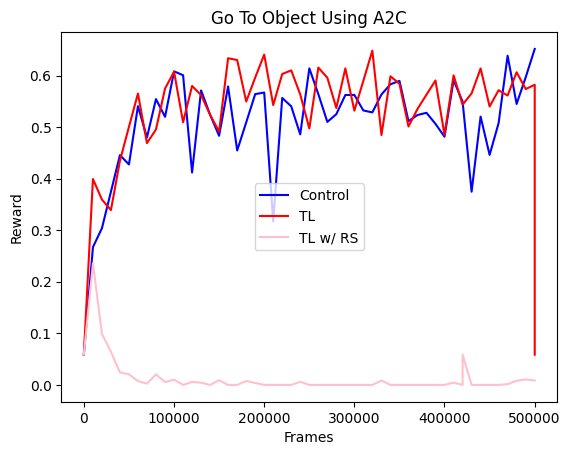

In [10]:
plot_eval([
    PlotEvalData("storage/a2c_fetch_control/eval.csv", "Control", show_min_max_fill=False), 
    PlotEvalData("storage/a2c_fetch_tl/eval.csv", "TL", color='red', frame_offset=500000, show_min_max_fill=False),
        PlotEvalData("storage/a2c_fetch_tl_w_rs/eval.csv", "TL w/ RS", color='pink', frame_offset=500000, show_min_max_fill=False),
], title="Go To Object Using A2C")
plt.show()